In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
# import os
# import shutil

# Measure the similarity of the spanned space by eigenvectors of $M^*$

Main data collections:
* eigvecs
* eigvals

In [ ]:
feature_dirs = {'soenet': '../../data/experiments/soenet/soenet_sg/2023_07_17/',
               'slowfast': '../../data/experiments/slowfast/slowfast_sg/2023_05_04-runtime-n/',
               '3dsift': '../../data/experiments/sift3d/sift3d_sg/2023_07_14/'}

# choose your feature
feature_id = '3dsift'
res_path = feature_dirs[feature_id]

# Load eigenvectors of a specific training set size

In [ ]:
num_M = 100
train_sz = 200

eigvals = []
eigvecs = []
for i in range(num_M):
    M = np.load(res_path+'matrices/finalM_50_'+str(train_sz)+'_'+str(i)+'.npy')
    vals, vecs = np.linalg.eig(M)
    sorted_vals = sorted(list(zip(np.arange(vals.shape[0]), np.real(vals))), key = lambda x: x[1], reverse=True)
    sorted_vals = np.array(sorted_vals)
    vals_i = sorted_vals[:, 0]
    vals = sorted_vals[:, 1]
    vecs = vecs[vals_i.astype(int)]
    eigvals.append(vals)
    eigvecs.append(vecs)

In [ ]:
print('eigvals = a list of {} numpy arrays of shape {}'.format(len(eigvals), eigvals[0].shape))
print('eigvecs = a list of {} numpy arrays of shape {}'.format(len(eigvecs), eigvecs[0].shape))

eigvals = a list of 100 numpy arrays of shape (384,)
eigvecs = a list of 100 numpy arrays of shape (384, 384)


# Visualize loaded eigenvectors

In [ ]:
num_obs = 9 # number of observations to visualize
obs = np.random.choice(np.arange(num_M), size=num_obs, replace=False)
print('Observations to be visualized = ', obs)

Observations to be visualized =  [22 48 55 56 83 95 86 26  6]


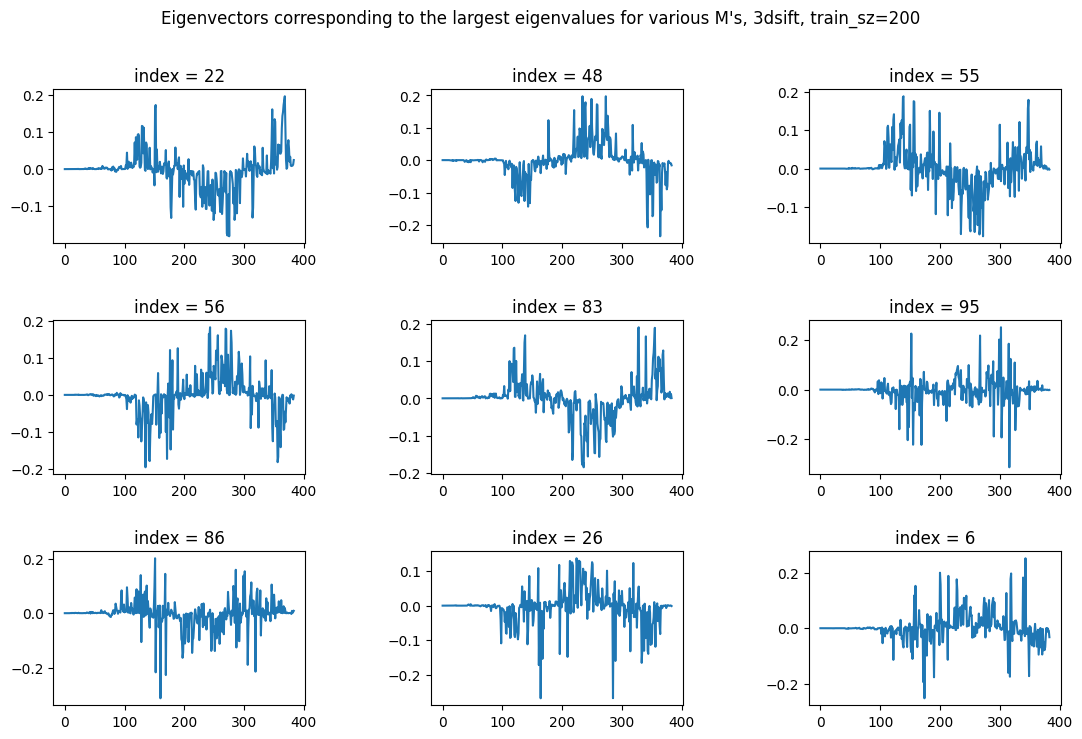

In [ ]:
x = np.arange(eigvecs[0].shape[0])
plt.figure(figsize=(13,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
i = 0
for ob_i in obs:
    i += 1
    plt.subplot(3,num_obs//3,i)
    plt.plot(x, np.real(eigvecs[ob_i][:, 0]))
    plt.title('index = {}'.format(ob_i))

_ = plt.suptitle('Eigenvectors corresponding to the largest eigenvalues for various M\'s, {}, train_sz={}'.format(feature_id, train_sz))
plt.savefig('image/eigvecs.png',dpi=300, bbox_inches = "tight")

# Space of the most important eigenvectors

In [ ]:
def project(orgSpace, projSpace):
    """
    Project each column of orgSpace to the column space of projSpace.
    Input:
        orgSpace - Df x num_eig
        projSpace - Df x num_eig
    Output:
        projs - Df x num_eig - projected vectors
    """
    projs = np.zeros_like(orgSpace)
    for vect_i in range(orgSpace.shape[1]):
        # compute projection of orgSpace[:, vect_i] on projSpace
        proj_i = projSpace @ projSpace.T @ orgSpace[:, vect_i]
        projs[:, vect_i] = proj_i

    return projs

In [ ]:
def projErr(eigvecs, ob_1, ob_2, num_eig, mode='avg', show_message=True):
    """
    mode: 'avg' for mean projection errors, 'max' for max errors, and 'org' for a stack of both errors.
    """

    A = eigvecs[ob_1][:, :num_eig]
    B = eigvecs[ob_2][:, :num_eig]
    if show_message:
        print('A = {}, cloumns of which are the {} largest eigenvectors of M in observation #{}'.format(A.shape, num_eig, ob_1))
        print('B = {}, cloumns of which are the {} largest eigenvectors of M in observation #{}'.format(B.shape, num_eig, ob_2))

    projA = project(A, B)
    if show_message:
        print('projA = {}, project of A columns on B\' column space.'.format(projA.shape))
    projB = project(B, A)
    if show_message:
        print('projB = {}, project of B columns on A\' column space.'.format(projB.shape))

    errA = np.linalg.norm(A - projA, axis=0)
    if show_message:
        # print('A - projA shape = ', (A - projA).shape)
        print('errA = ', errA)
    errB = np.linalg.norm(B - projB, axis=0)
    if show_message:
        print('errB = ', errB)

    if mode == 'org':
        return np.stack((errA, errB), axis=0)
    elif mode == 'avg':
        return np.mean(np.stack((errA, errB), axis=0), axis=0)
    elif mode == 'max':
        return np.max(np.stack((errA, errB), axis=0), axis=0)

In [ ]:
def show2projErr(eigvecs, ob_1, ob_2, num_eig, mode='avg', show_message=True):
    errAvg = projErr(eigvecs, ob_1, ob_2, num_eig, mode, show_message)
    if mode=='avg':
        print('errAvg = ', errAvg)
    elif mode=='max':
        print('errMax = ', errAvg)

    # show ob_1 vectors
    x = np.arange(eigvecs[0].shape[0])
    plt.figure(figsize=(30,3))
    for vect_i in range(num_eig):
        plt.subplot(1, num_eig, vect_i+1)
        plt.plot(x, eigvecs[ob_1][:, vect_i])
        plt.title(vect_i+1)
    plt.suptitle('Observation #{}'.format(ob_1))

    # show ob_2 vectors
    x = np.arange(eigvecs[0].shape[0])
    plt.figure(figsize=(30,3))
    for vect_i in range(num_eig):
        plt.subplot(1, num_eig, vect_i+1)
        plt.plot(x, eigvecs[ob_2][:, vect_i])
        plt.title(vect_i+1)
    plt.suptitle('Observation #{}'.format(ob_2))

    return errAvg

## Projection errors between two observations

A = (384, 5), cloumns of which are the 5 largest eigenvectors of M in observation #35
B = (384, 5), cloumns of which are the 5 largest eigenvectors of M in observation #45
projA = (384, 5), project of A columns on B' column space.
projB = (384, 5), project of B columns on A' column space.
errA =  [0.89510787 0.97588426 0.9667102  0.98630525 0.96680566]
errB =  [0.88744316 0.98496255 0.98072617 0.99135884 0.9451377 ]
errAvg =  [0.89127552 0.98042341 0.97371819 0.98883204 0.95597168]


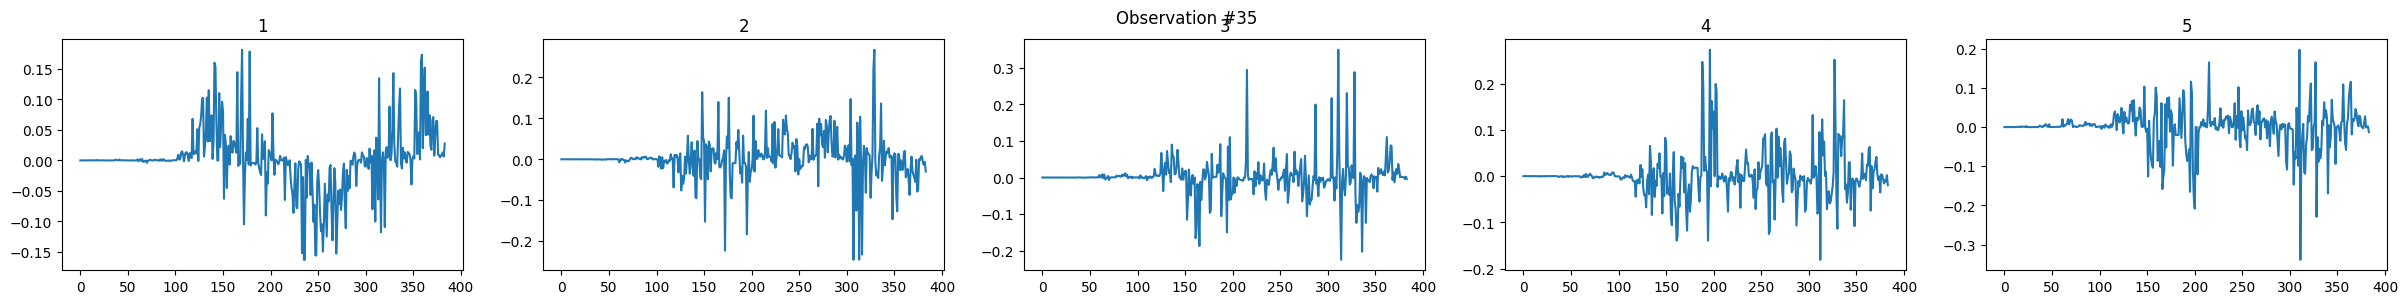

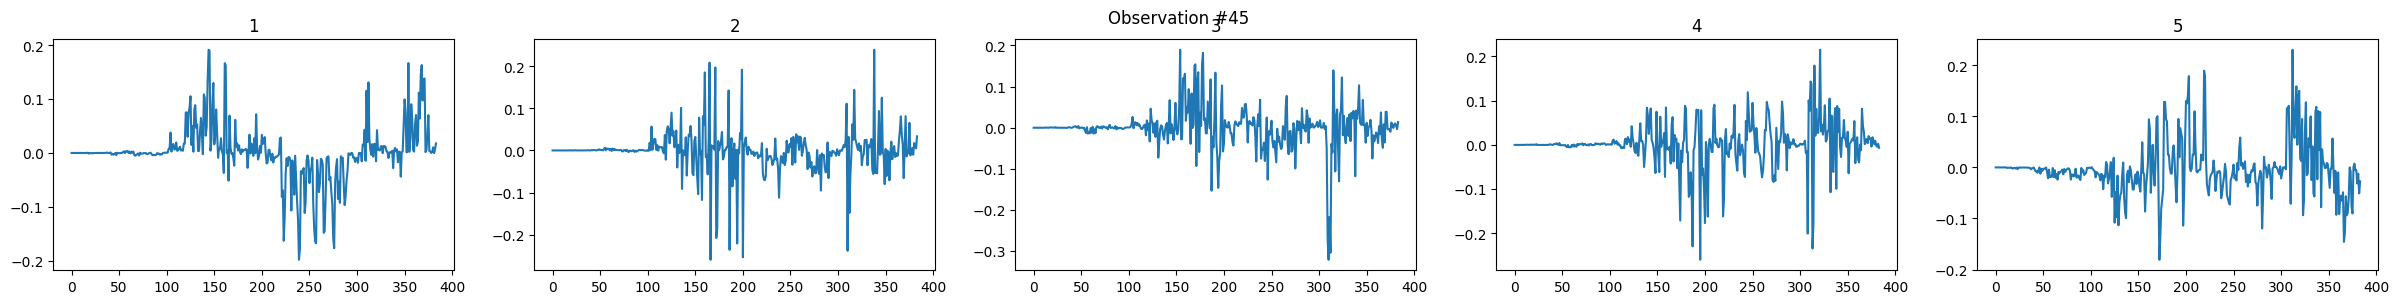

In [ ]:
# compute the projection error of two observations for the 5 eigenvectors corresponding to the 5 largest eigenvalues
num_eig = 5
ob_1 = 35
ob_2 = 45

errAvg = show2projErr(eigvecs, ob_1, ob_2, num_eig, mode='avg', show_message=True)

Mag. of the diff. =  1.0986637248502835


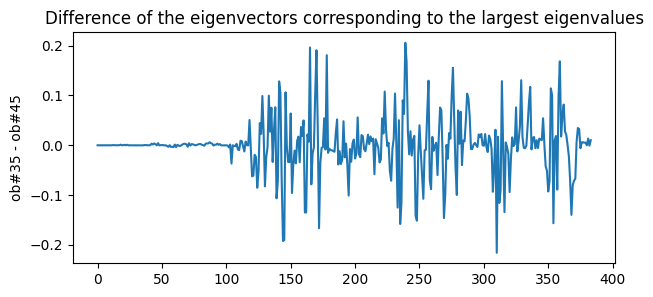

In [ ]:
# difference of two corresponding eigenvectors
x = np.arange(eigvecs[ob_1].shape[0])
y = eigvecs[ob_1][:, 0] - eigvecs[ob_2][:, 0]
plt.figure(figsize=(7,3))
plt.plot(x, y)
plt.title('Difference of the eigenvectors corresponding to the largest eigenvalues')
_ = plt.ylabel('ob#{} - ob#{}'.format(ob_1, ob_2))

print('Mag. of the diff. = ', np.linalg.norm(y))

# Low-pass filter on the eigenvectors

In [ ]:
def bandstop(length, wstop_pi, wstart_pi, show_plot=True):
    bandstop = np.ones(length)
    bandstop[int(wstop_pi*length/2):int(wstart_pi*length/2)] = 0
    bandstop[length-int(wstart_pi*length/2):length-int(wstop_pi*length/2)] = 0

    if show_plot:
        plt.figure()
        plt.plot(2*np.arange(length)/length, bandstop)
        plt.xlabel('frequency ($\omega$/$\pi$)')
        plt.ylabel('magnitude')
        _ = plt.title('Bandstop Filter')
        plt.show()

    return bandstop

In [ ]:
def apply_filt(filt, signals):
    """
    filt - frequency response of the filter
    signals - Df x N signals are columns, in time domain

    Output:
    signals_filt - Df x N filtered signals, in time domain
    """
    signals_fft = fft(signals, axis=0)
    signals_filt_fft = np.matmul(np.diag(filt), signals_fft)
    signals_filt = ifft(signals_filt_fft, axis=0)

    return signals_filt

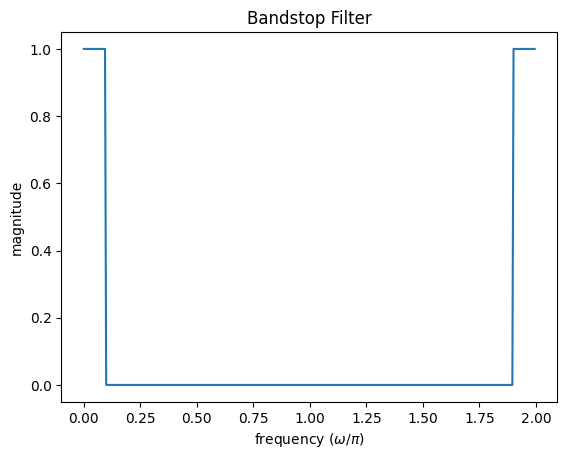

In [ ]:
length = eigvecs[ob_1].shape[0]
wstop_pi = 0.1
wstart_pi = 1.0

bstp = bandstop(length, wstop_pi, wstart_pi, show_plot=True)

In [ ]:
eigvecs_filt = []

for ob_i in range(num_M):
    eigvecs_filt.append(apply_filt(bstp, eigvecs[ob_i]))

## Illustrate the results of lowpass filter

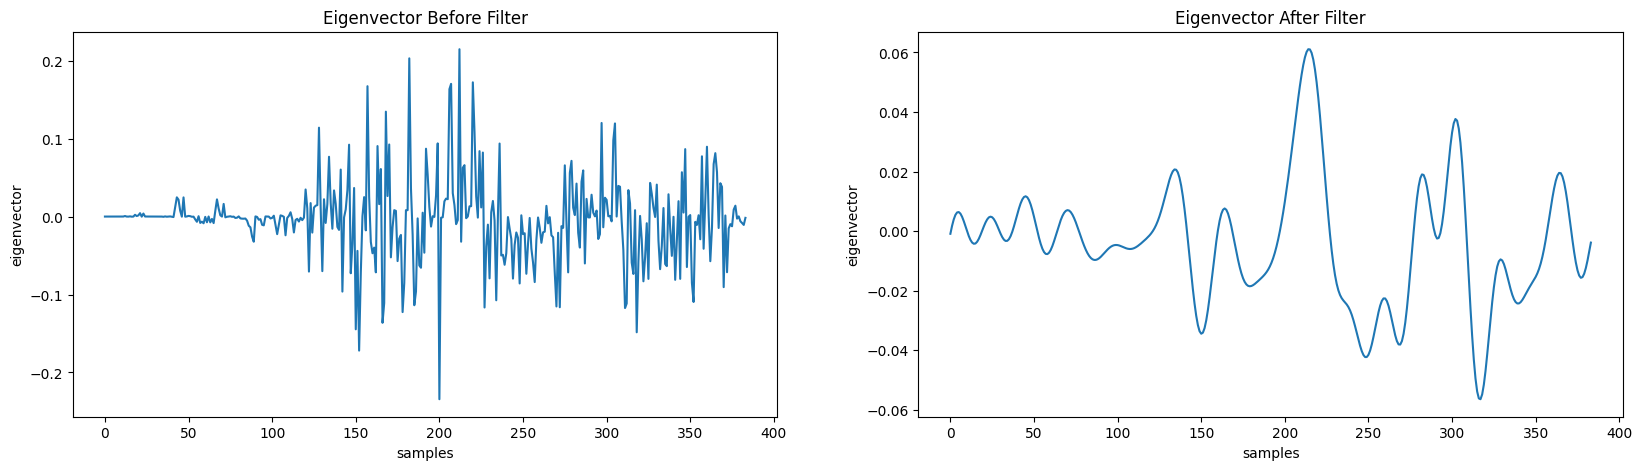

In [ ]:
ob_i = 50
vect_i = 20
length = eigvecs[0].shape[0]

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.arange(length), eigvecs[ob_i][:,vect_i])
plt.xlabel('samples')
plt.ylabel('eigenvector')
_ = plt.title('Eigenvector Before Filter')
plt.subplot(1,2,2)
plt.plot(np.arange(length), eigvecs_filt[ob_i][:,vect_i])
plt.xlabel('samples')
plt.ylabel('eigenvector')
_ = plt.title('Eigenvector After Filter')
plt.show()

## Projection errors between two filtered observations

A = (384, 5), cloumns of which are the 5 largest eigenvectors of M in observation #35
B = (384, 5), cloumns of which are the 5 largest eigenvectors of M in observation #45
projA = (384, 5), project of A columns on B' column space.
projB = (384, 5), project of B columns on A' column space.
errA =  [0.40595843 0.31861402 0.34048936 0.40695464 0.3541656 ]
errB =  [0.396742   0.28704093 0.48027745 0.3244325  0.53197932]
errAvg =  [0.40135022 0.30282747 0.4103834  0.36569357 0.44307246]


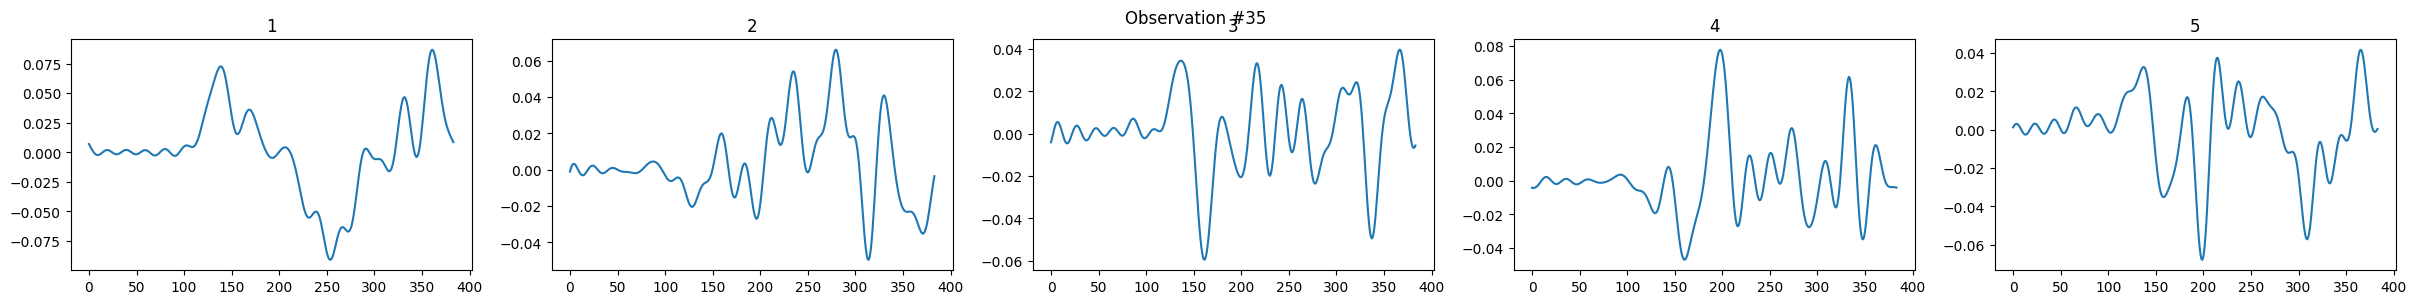

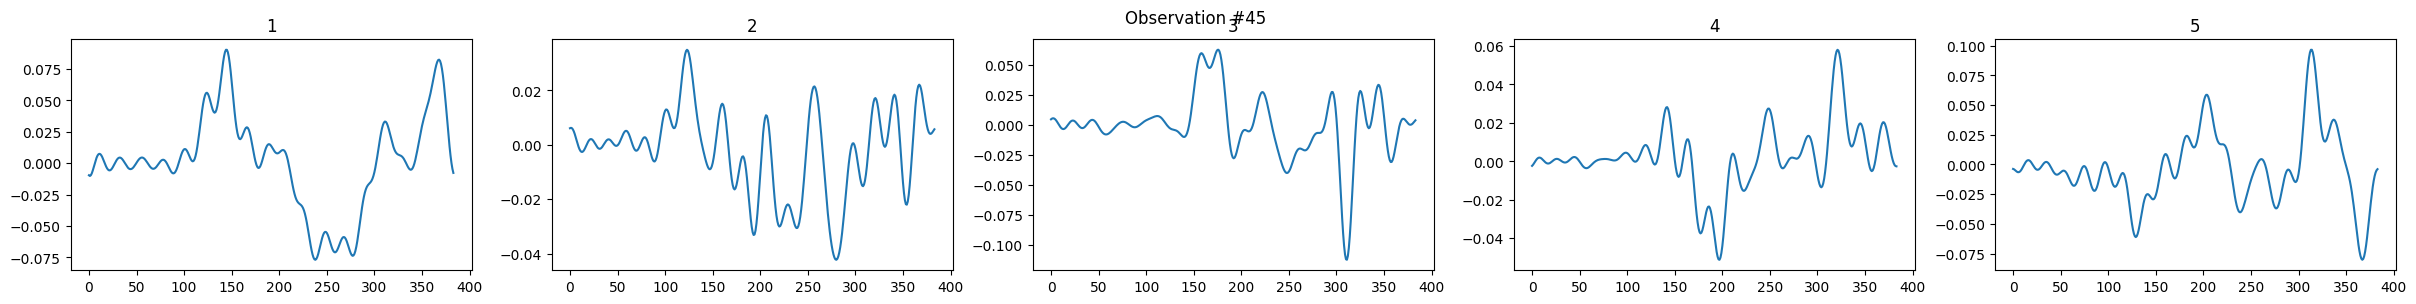

In [ ]:
# compute the projection error of two observations for the 5 eigenvectors corresponding to the 5 largest eigenvalues
# num_eig = 5
# ob_1 = 35
# ob_2 = 45

errAvg = show2projErr(eigvecs_filt, ob_1, ob_2, num_eig, mode='avg', show_message=True)

Mag. of the diff. =  0.3442184464681115


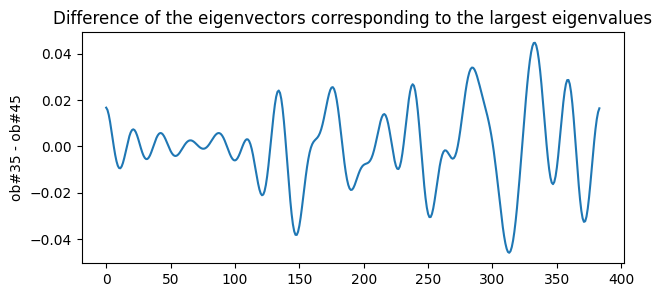

In [ ]:
# difference of two corresponding eigenvectors
x = np.arange(eigvecs_filt[ob_1].shape[0])
y = eigvecs_filt[ob_1][:, 0] - eigvecs_filt[ob_2][:, 0]
plt.figure(figsize=(7,3))
plt.plot(x, y)
plt.title('Difference of the eigenvectors corresponding to the largest eigenvalues')
_ = plt.ylabel('ob#{} - ob#{}'.format(ob_1, ob_2))

print('Mag. of the diff. = ', np.linalg.norm(y))